In [1]:
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

import datetime

import os
import time
from tqdm import tqdm

from utils import helper

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
# Original colors
orange = '#E69F00'
blue = '#56B4E9'
green = '#009E73'
# Darker shades
darker_orange = '#A87000'
darker_blue = '#3A81A3'
darker_green = '#00674D'
# Lighter shades
lighter_orange = '#FFD080'
lighter_blue = '#7FCFFF'
lighter_green = '#33E6B2'

In [3]:
# Original colors
orange = '#E69F00'
blue = '#56B4E9'
green = '#009E73'

# Darker shades
darker_orange = '#A65200'
darker_blue = '#2E5B7A'
darker_green = '#004C39'

# Lighter shades
lighter_orange = '#FFE0A0'
lighter_blue = '#A0E4FF'
lighter_green = '#66F2D4'

In [4]:
# Load Datasets

homelocations_merged=pd.read_parquet('../data_created/homelocations_merged.parquet')
evacuated_people = helper.upload_list_txt('../data_created/evacuated.txt')

grouped_data_fraction1 = pd.read_csv('../data_created/fraction/grouped_data_fraction1.csv') #notaffected
grouped_data_fraction2 = pd.read_csv('../data_created/fraction/grouped_data_fraction2.csv') #evacuated
grouped_data_fraction1_ses = pd.read_csv('../data_created/fraction/grouped_data_fraction1_ses.csv') #notaffected
grouped_data_fraction2_ses = pd.read_csv('../data_created/fraction/grouped_data_fraction2_ses.csv') #evacuated

result = helper.upload_if_exists('../data_created/bootstrapped_merged_noses.parquet')
result_evac = helper.upload_if_exists('../data_created/bootstrapped_evac_noses.parquet')
result_ses = helper.upload_if_exists('../data_created/bootstrapped_merged_ses.parquet')
result_evac_ses = helper.upload_if_exists('../data_created/bootstrapped_evac_ses.parquet')

rdd_df = pd.read_csv('../data_created/fraction/rdd_df.csv')
dd_df = pd.read_csv('../data_created/fraction/dd_df.csv')
rdd_df_ses = pd.read_csv('../data_created/fraction/rdd_df_ses.csv')
dd_df_ses = pd.read_csv('../data_created/fraction/dd_df_ses.csv')

rdd_df_mean = pd.read_csv('../data_created/fraction/rdd_df_mean.csv')
dd_df_mean = pd.read_csv('../data_created/fraction/dd_df_mean.csv')
rdd_df_ses_mean = pd.read_csv('../data_created/fraction/rdd_df_ses_mean.csv')
dd_df_ses_mean = pd.read_csv('../data_created/fraction/dd_df_ses_mean.csv')
rdd_df_median = pd.read_csv('../data_created/fraction/rdd_df_median.csv')
dd_df_median = pd.read_csv('../data_created/fraction/dd_df_median.csv')
rdd_df_ses_median = pd.read_csv('../data_created/fraction/rdd_df_ses_median.csv')
dd_df_ses_median = pd.read_csv('../data_created/fraction/dd_df_ses_median.csv')

In [5]:
for df in [homelocations_merged, grouped_data_fraction1, grouped_data_fraction2, grouped_data_fraction1_ses, grouped_data_fraction2_ses]:
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])


In [6]:
plt.rcParams.update({'font.size': 13, 'font.style': 'normal', 'figure.facecolor':'white'})

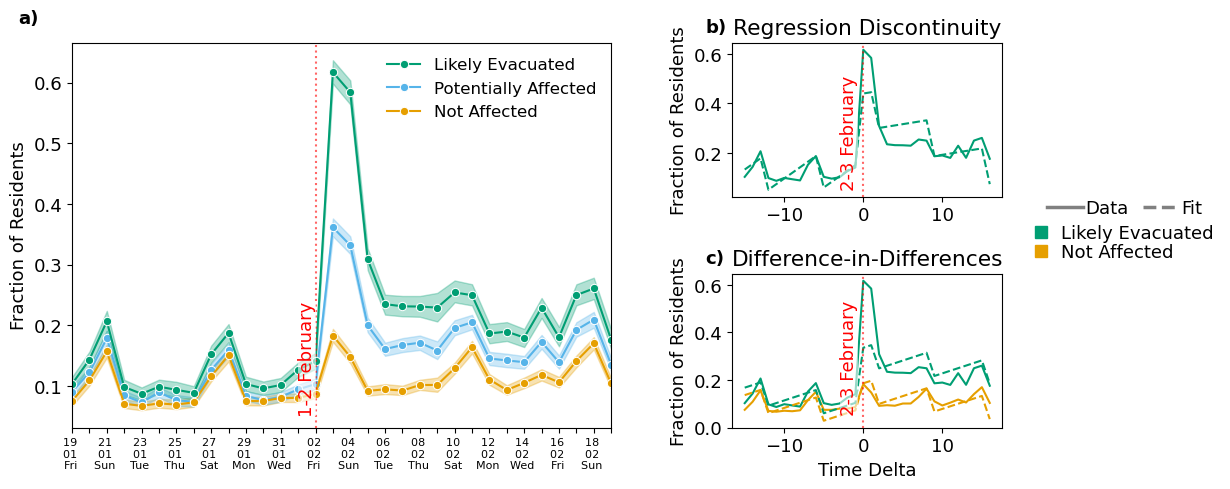

In [7]:
######## Figure 1 ########

fig, axs = plt.subplot_mosaic([
    ['a', 'b',],
    ['a', 'c']], 
    #layout="constrained"
    figsize =(12, 5), height_ratios=[1,1],width_ratios=[2,1],
                            gridspec_kw={'wspace':0.3, 'hspace':0.5})

# First subplot
sns.lineplot(data=grouped_data_fraction1, x='date', y='PHONE_ID', hue='affected', marker='o', hue_order=[1, 0],
             palette=[blue, orange], ax=axs['a'])
sns.lineplot(data=grouped_data_fraction2, x='date', y='PHONE_ID', marker='o', label='Evacuated', color=green, ax=axs['a'])

# Adding labels and title
axs['a'].set_xlabel('')
axs['a'].set_ylabel('Fraction of Residents')

# Displaying the plot
axs['a'].set_xlim([datetime.datetime(2024, 1, 19), datetime.datetime(2024, 2, 19)])

# Set x-axis to display only the dates
axs['a'].xaxis.set_major_locator(mdates.DayLocator())
axs['a'].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

axs['a'].axvline(x=datetime.datetime(2024, 2, 2), color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['a'].text( x=datetime.datetime(2024, 2, 1), y=0.05, s='1-2 February',
        fontsize=13, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)


unique_dates = homelocations_merged['date'].unique()
axs['a'].set_xticks(unique_dates)
xticklabels = [date.strftime('%d \n%m \n%a ') if i % 2 == 0 else '' for i, date in enumerate(unique_dates)]
axs['a'].set_xticklabels(xticklabels, fontsize=8)

# Hide the legend element corresponding to the middle plot object
handles, labels = axs['a'].get_legend_handles_labels()
new_order = [2, 0, 1]  # New order indices for 'Likely Evacuated', 'Potentially Affected', 'Not Affected'
handles = [handles[i] for i in new_order]
labels = [labels[i] for i in new_order]
labels = ['Likely Evacuated', 'Potentially Affected', 'Not Affected']
axs['a'].legend(handles, labels, title='', fontsize=12, frameon=False)

# Plot confidence intervals
for i, color in enumerate([orange, blue]):
    subset = result[result['affected'] == i]
    axs['a'].fill_between(subset['date'], subset['ci_lower'], subset['ci_upper'], alpha=0.3, color=color)
axs['a'].fill_between(result_evac['date'], result_evac['ci_lower'], result_evac['ci_upper'], alpha=0.3, color=green)

# Second subplot
rdd_df.plot.line(ax=axs['b'], x="time_delta", y="PHONE_ID", color=green, legend=False)
rdd_df.plot(x="time_delta", y="predictions", ax=axs['b'], color=green, linestyle='--', legend=False)

axs['b'].axvline(x=0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['b'].text(x=-3, y=0.05, s='2-3 February',
        fontsize=13, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)

axs['b'].set_title("Regression Discontinuity")
axs['b'].set_ylabel('Fraction of Residents')
axs['b'].set_xlabel('')


# Third subplot
# Plot original data
sns.lineplot(ax=axs['c'], x='time_delta', y='value', hue='group', data=dd_df, hue_order=['PHONE_ID_evac', 'PHONE_ID_notaff'], palette=[green, orange], legend=False)
# Plot fitted predictions
sns.lineplot(ax=axs['c'], x='time_delta', y='predictions', hue='group', data=dd_df, hue_order=['PHONE_ID_evac', 'PHONE_ID_notaff'], palette=[green, orange], linestyle='--', legend=False)

axs['c'].axvline(x=0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['c'].text(x=-3, y=0.05, s='2-3 February',
        fontsize=13, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)

# Set plot labels and legend
axs['c'].set_title('Difference-in-Differences')
axs['c'].set_xlabel('Time Delta')
axs['c'].set_ylabel('Fraction of Residents')

# plt.savefig('visuals_/fraction_moved.pdf')

c_differences   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  markersize=8, label=mod)) for c,mod in zip([green, orange],
                                                                                                                           ['Likely Evacuated','Not Affected'])]

lines =[(Line2D([0],[0], marker='', color='grey', markerfacecolor='grey',ls=l,  lw=2.5, label=mod)) for l,mod in zip(['-', '--'],['Data','Fit'])]

fig.legend(handles=lines,bbox_to_anchor=(1.08,0.6), fontsize = 13, ncols= 2, frameon=False,columnspacing=0.8, handletextpad=0.1,labelspacing=0.1)
fig.legend(handles=c_differences,bbox_to_anchor=(1.09,0.55), fontsize = 13, title= '', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)

plots_l = ['a)', 'b)', 'c)']
for ia, ax in enumerate(fig.axes): 
    x,y = -0.1,1.04
    ax.text(x,y,  plots_l[ia],
        color = 'k',#'lightgreen',
        horizontalalignment='left',
        verticalalignment='bottom',
        weight = 'bold',
        transform=ax.transAxes,fontsize = 13)


plt.savefig('../visuals_created/fraction_moved.pdf', bbox_inches = 'tight')

##########################


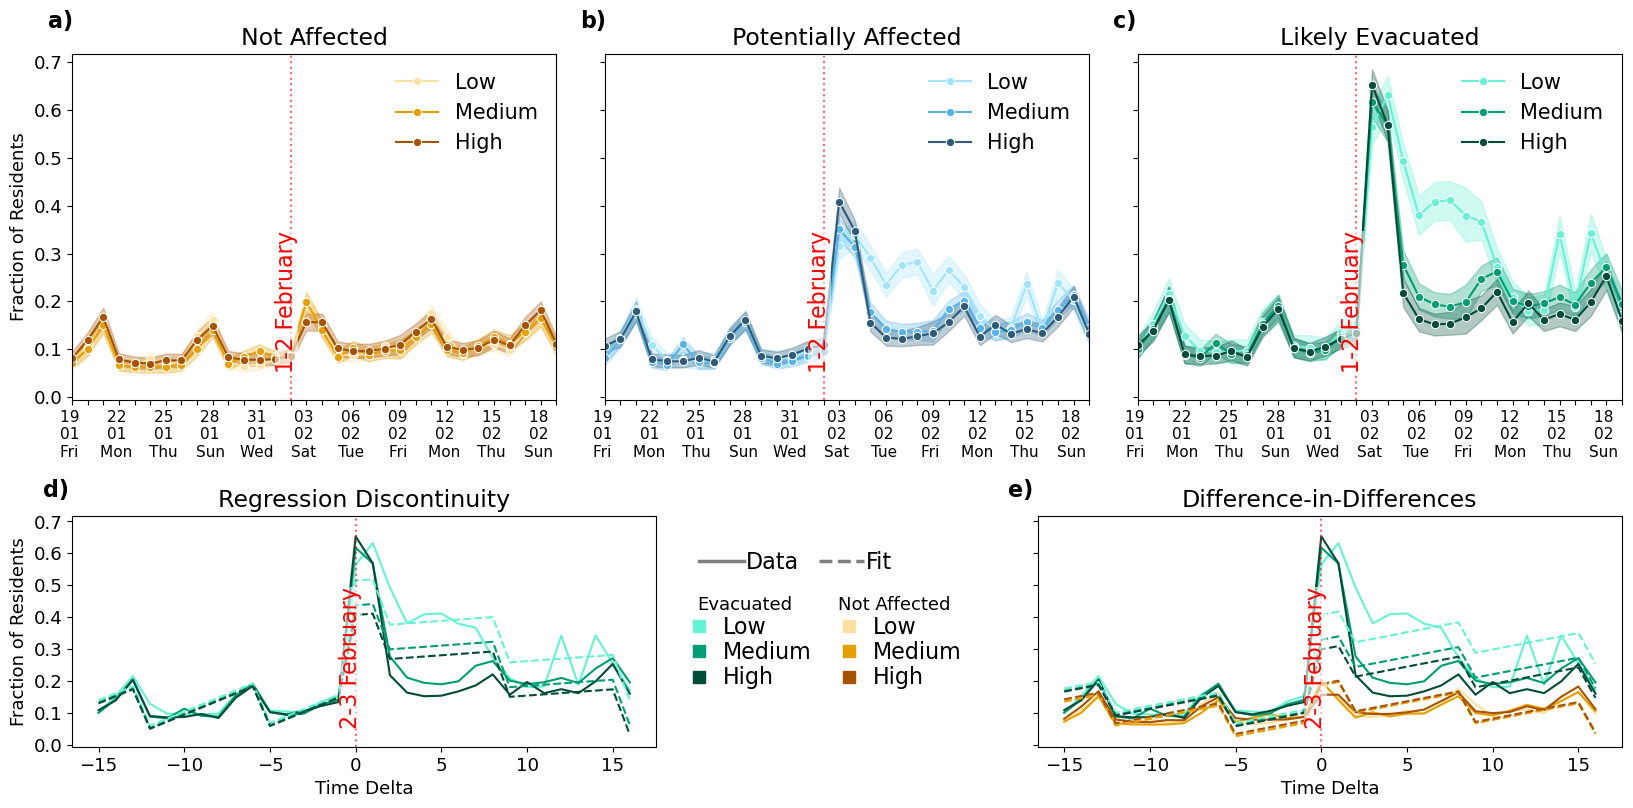

In [8]:
######## Figure 2 ########

fig, axs = plt.subplot_mosaic([
    ['a', 'b', 'c',],
    ['d', 'ee', 'e']], 
    #layout="constrained"
    figsize =(20, 9), height_ratios=[1.5,1],width_ratios=[1,1,1],
                             sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0.4})

for e in ['ee']: fig.delaxes(axs[e])

b = axs['d'].get_position()
b.x1 = b.x1 + 0.05
axs['d'].set_position(b)

b = axs['e'].get_position()
b.x0 = b.x0 - 0.05
axs['e'].set_position(b)


# Creating the line plots on the first row
sns.lineplot(data=grouped_data_fraction1_ses[grouped_data_fraction1_ses['affected'] == 0], x='date', y='PHONE_ID', 
             hue='quantile_pop_bins_percent_bachelor_home', marker='o', hue_order=['Low','Medium','High'], 
             ax=axs['a'], legend=True, palette=[lighter_orange,orange,darker_orange])
sns.lineplot(data=grouped_data_fraction1_ses[grouped_data_fraction1_ses['affected'] == 1], x='date', y='PHONE_ID', 
             hue='quantile_pop_bins_percent_bachelor_home', marker='o', hue_order=['Low','Medium','High'], 
             ax=axs['b'], legend=True, palette=[lighter_blue,blue,darker_blue])
sns.lineplot(data=grouped_data_fraction2_ses, x='date', y='PHONE_ID', 
             hue='quantile_pop_bins_percent_bachelor_home', marker='o', hue_order=['Low','Medium','High'], 
             ax=axs['c'], legend=True, palette=[lighter_green,green,darker_green])

titles = ['Not Affected', 'Potentially Affected', 'Likely Evacuated']

unique_dates = homelocations_merged.drop_duplicates(subset=['date'])['date'].unique()
xticklabels = [date.strftime('%d \n%m \n%a ') if i % 3 == 0 else '' for i, date in enumerate(unique_dates)]

for ax, title in zip([axs['a'], axs['b'], axs['c']], titles):
    # Adding labels and title
    ax.set_title(title, size=17)
    ax.set_xlabel('')
    ax.set_ylabel('Fraction of Residents')

    ax.set_xlim([datetime.datetime(2024, 1, 19), datetime.datetime(2024, 2, 19)])
    
    # Set x-axis to display only the dates
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    ax.axvline(x=datetime.datetime(2024, 2, 2), color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
    ax.text( x=datetime.datetime(2024, 2, 1), y=0.05, s='1-2 February',
            fontsize=16, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)
    
    # Setting x-ticks and labels based on homelocations_warned dataframe
    ax.set_xticks(unique_dates)
    ax.set_xticklabels(xticklabels, fontsize=11)

# Hide the legend element corresponding to the middle plot object

for ax in [axs['a'], axs['b'], axs['c']]:
    handles, labels = ax.get_legend_handles_labels()
    custom_labels = ['Low', 'Medium', 'High']
    ax.legend(handles, custom_labels, title='', fontsize=15, loc='upper right', frameon=False)

for ses, color in zip(['Low', 'Medium', 'High'], [lighter_orange,orange,darker_orange]):
    subset = result_ses[(result_ses['quantile_pop_bins_percent_bachelor_home']==ses)&(result_ses['affected']==0)]
    axs['a'].fill_between(subset['date'], subset['ci_lower'], subset['ci_upper'], alpha=0.3, color=color)

for ses, color in zip(['Low', 'Medium', 'High'], [lighter_blue,blue,darker_blue]):
    subset = result_ses[(result_ses['quantile_pop_bins_percent_bachelor_home']==ses)&(result_ses['affected']==1)]
    axs['b'].fill_between(subset['date'], subset['ci_lower'], subset['ci_upper'], alpha=0.3, color=color)

for ses, color in zip(['Low', 'Medium', 'High'], [lighter_green,green,darker_green]):
    subset = result_evac_ses[result_evac_ses['quantile_pop_bins_percent_bachelor_home']==ses]
    axs['c'].fill_between(subset['date'], subset['ci_lower'], subset['ci_upper'], alpha=0.3, color=color)

for ax in [axs['b'], axs['c']]:
    ax.set_ylabel('')
    ax.tick_params(labelleft=False)


# Bottom left

# Creating the subplot for Regression Discontinuity
sns.lineplot(ax=axs['d'], x='time_delta', y='PHONE_ID', hue='quantile_pop_bins_percent_bachelor_home', 
             data=rdd_df_ses, palette=[lighter_green,green,darker_green], legend=False)

sns.lineplot(ax=axs['d'], x='time_delta', y='predictions', hue='quantile_pop_bins_percent_bachelor_home', 
             data=rdd_df_ses, palette=[lighter_green,green,darker_green], linestyle='--', legend=False)

axs['d'].axvline(0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['d'].text(x=-1, y=0.05, s='2-3 February',
        fontsize=16, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)

axs['d'].set_title("Regression Discontinuity", size=17)
axs['d'].set_ylabel('Fraction of Residents')
axs['d'].set_xlabel('Time Delta')


# Bottom right 

dd_df_ses['combined_hue'] = dd_df_ses['group'].astype(str) + '_' + dd_df_ses['quantile_pop_bins_percent_bachelor_home'].astype(str)

# Creating the subplot for Difference-in-Differences
sns.lineplot(ax=axs['e'], x='time_delta', y='value', hue='combined_hue', data=dd_df_ses, 
             palette=[lighter_orange,orange,darker_orange,lighter_green,green,darker_green], legend=False)

sns.lineplot(ax=axs['e'], x='time_delta', y='predictions', hue='combined_hue', data=dd_df_ses, 
             palette=[lighter_orange,orange,darker_orange,lighter_green,green,darker_green], linestyle='--', legend=False)

axs['e'].axvline(0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['e'].text(x=-1, y=0.05, s='2-3 February',
        fontsize=16, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)

axs['e'].set_title("Difference-in-Differences", size=17)
axs['e'].set_ylabel('Fraction of Residents')
axs['e'].set_xlabel('Time Delta')

# handles, labels = axs['e'].get_legend_handles_labels()
# labels = ['Not Affected - Low', 'Not Affected - Medium', 'Not Affected - High', 
#           'Evacuated - Low', 'Evacuated - Medium', 'Evacuated - High',
#           'Fitted Line - Not Affected - Low', 'Fitted Line - Not Affected - Medium', 'Fitted Line - Not Affected - High',
#           'Fitted Line - Evacuated - Low', 'Fitted Line - Evacuated - Medium', 'Fitted Line - Evacuated - High',
#           '2-3 February']

c_evacuated   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  markersize=8, label=mod)) for c,mod in zip([lighter_green, green, darker_green],
                                                                                                                           ['Low','Medium','High'])]
c_notaffected =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  markersize=8, label=mod)) for c,mod in zip([lighter_orange, orange, darker_orange],
                                                                                                                           ['Low','Medium','High'])]

lines =[(Line2D([0],[0], marker='', color='grey', markerfacecolor='grey',ls=l,  lw=2.5, label=mod)) for l,mod in zip(['-', '--'],['Data','Fit'])]

fig.legend(handles=lines,bbox_to_anchor=(0.545  ,0.35), fontsize = 16, ncols= 2, frameon=False,columnspacing=0.9, handletextpad=0.1,labelspacing=0.15)
fig.legend(handles=c_evacuated,bbox_to_anchor=(0.505  ,0.3), fontsize = 16, title= 'Evacuated', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)
fig.legend(handles=c_notaffected,bbox_to_anchor=(0.58  ,0.3), fontsize = 16, title= 'Not Affected', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)

plots_l = ['a)', 'b)', 'c)', 'd)', 'e)']
for ia, ax in enumerate(fig.axes): 
    x,y = -0.05,1.06
    ax.text(x,y,  plots_l[ia],
        color = 'k',#'lightgreen',
        horizontalalignment='left',
        verticalalignment='bottom',
        weight = 'bold',
        transform=ax.transAxes,fontsize = 16)


plt.savefig('../visuals_created/fraction_moved_ses.pdf', bbox_inches = 'tight')

##########################


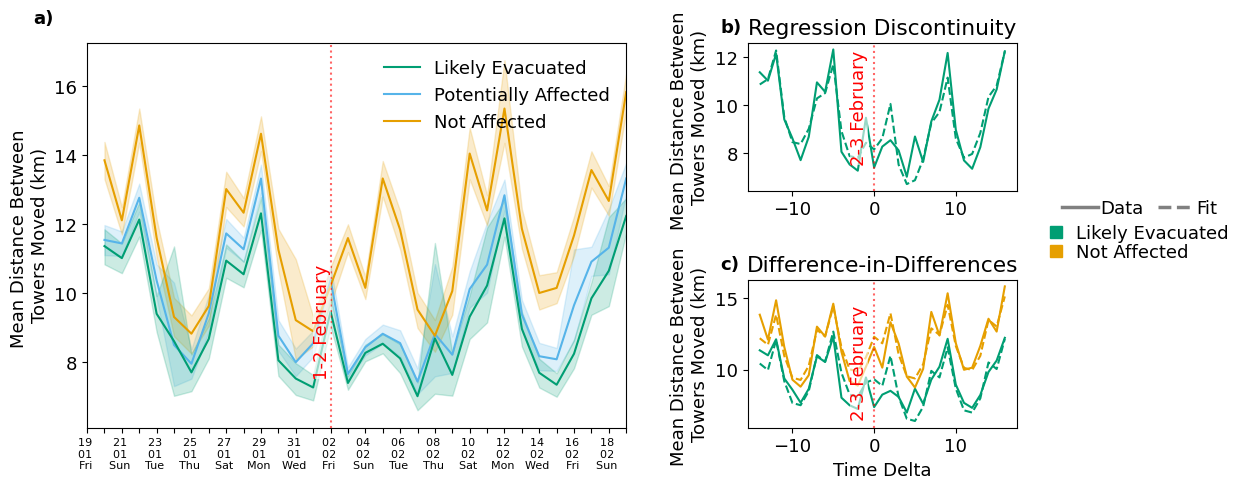

In [9]:
######## Figure 3 ########

fig, axs = plt.subplot_mosaic([
    ['a', 'b',],
    ['a', 'c']], 
    #layout="constrained"
    figsize =(12, 5), height_ratios=[1,1],width_ratios=[2,1],
                            gridspec_kw={'wspace':0.3, 'hspace':0.6})

sns.lineplot(data=homelocations_merged[~(homelocations_merged['home_bts_id'].isna())&(homelocations_merged['distance_km'] > 0)], 
             y='distance_km', x='date', legend=True, ax=axs['a'],
            errorbar='ci', n_boot=1000, seed=10, estimator='mean', hue='affected', hue_order=[1, 0],
            palette=[blue, orange])
sns.lineplot(data=homelocations_merged[homelocations_merged['PHONE_ID'].isin(evacuated_people)&(homelocations_merged['distance_km'] > 0)], 
             y='distance_km', x='date', legend=True, ax=axs['a'], 
             errorbar='ci', n_boot=1000, seed=10, estimator='mean', label='Evacuated',
             color=green)
axs['a'].tick_params(axis='x')
axs['a'].set_xlabel('')
axs['a'].set_ylabel('Mean Distance Between \nTowers Moved (km)')
axs['a'].set_xlim([datetime.datetime(2024, 1, 19), datetime.datetime(2024, 2, 19)])

# Set x-axis to display only the dates
axs['a'].xaxis.set_major_locator(mdates.DayLocator())
axs['a'].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

axs['a'].axvline(x=datetime.datetime(2024, 2, 2), color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['a'].text( x=datetime.datetime(2024, 2, 1), y=7.5, s='1-2 February',
        fontsize=13, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)


unique_dates = homelocations_merged['date'].unique()
axs['a'].set_xticks(unique_dates)
xticklabels = [date.strftime('%d \n%m \n%a ') if i % 2 == 0 else '' for i, date in enumerate(unique_dates)]
axs['a'].set_xticklabels(xticklabels, fontsize=8)

# Hide the legend element corresponding to the middle plot object
handles, labels = axs['a'].get_legend_handles_labels()
new_order = [2, 0, 1]
handles = [handles[i] for i in new_order]
labels = [labels[i] for i in new_order]
custom_labels = ['Likely Evacuated', 'Potentially Affected', 'Not Affected', '1-2 February']
axs['a'].legend(handles, custom_labels, title='', loc='upper right', frameon=False)

# Top Right

rdd_df_mean.plot.line(ax=axs['b'], x="time_delta", y="distance_km", color=green, legend=False)
rdd_df_mean.plot(x="time_delta", y="predictions", ax=axs['b'], color=green, linestyle='--', legend=False)

axs['b'].axvline(x=0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['b'].text( x=-3, y=7.5, s='2-3 February',
        fontsize=13, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)


axs['b'].set_title("")
axs['b'].set_xlabel('')
axs['b'].set_ylabel('Mean Distance Between \nTowers Moved (km)')
axs['b'].set_title("Regression Discontinuity")


# Bottom Right
# Plot original data
sns.lineplot(ax=axs['c'], x='time_delta', y='value', hue='group', data=dd_df_mean,
            hue_order=['distance_km_evac', 'distance_km_notaff'], palette=[green, orange], legend=False)
# Plot fitted predictions
sns.lineplot(ax=axs['c'], x='time_delta', y='predictions', hue='group', data=dd_df_mean, linestyle='--',
            hue_order=['distance_km_evac', 'distance_km_notaff'], palette=[green, orange], legend=False)

axs['c'].axvline(x=0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['c'].text( x=-3, y=6.5, s='2-3 February',
        fontsize=13, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)

# Set plot labels and legend
axs['c'].set_title('')
axs['c'].set_xlabel('Time Delta')
axs['c'].set_ylabel('Mean Distance Between \nTowers Moved (km)')
axs['c'].set_title("Difference-in-Differences")

# Legend
c_differences   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  markersize=8, label=mod)) for c,mod in zip([green, orange],
                                                                                                                           ['Likely Evacuated','Not Affected'])]
lines =[(Line2D([0],[0], marker='', color='grey', markerfacecolor='grey',ls=l,  lw=2.5, label=mod)) for l,mod in zip(['-', '--'],['Data','Fit'])]

fig.legend(handles=lines,bbox_to_anchor=(1.08,0.6), fontsize = 13, ncols= 2, frameon=False,columnspacing=0.8, handletextpad=0.1,labelspacing=0.1)
fig.legend(handles=c_differences,bbox_to_anchor=(1.09,0.55), fontsize = 13, title= '', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)

plots_l = ['a)', 'b)', 'c)']
for ia, ax in enumerate(fig.axes): 
    x,y = -0.1,1.04
    ax.text(x,y,  plots_l[ia],
        color = 'k',#'lightgreen',
        horizontalalignment='left',
        verticalalignment='bottom',
        weight = 'bold',
        transform=ax.transAxes,fontsize = 13)

plt.savefig('../visuals_created/km_moved_mean.pdf', bbox_inches = 'tight')
    
##########################

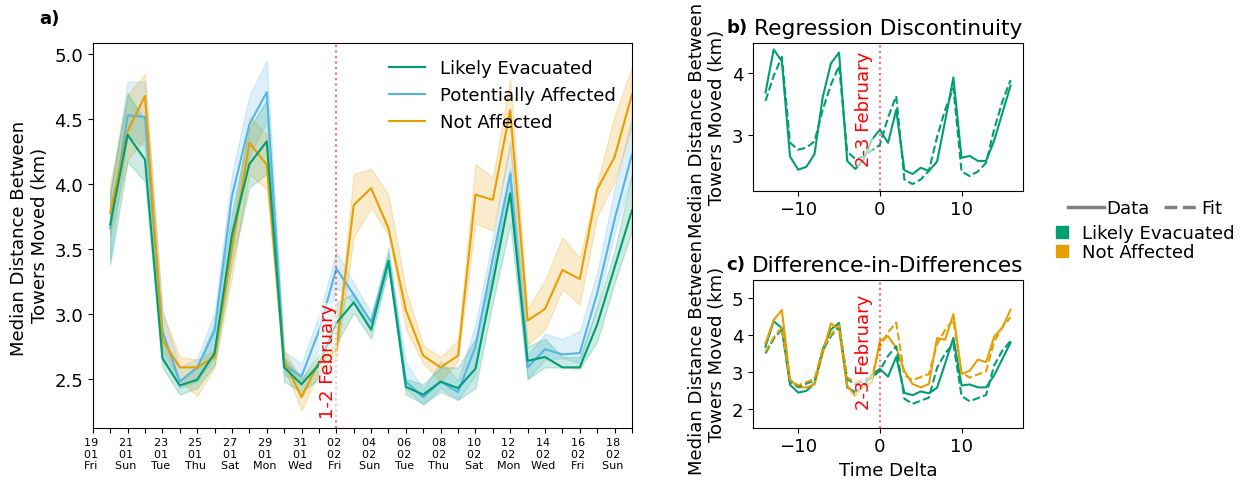

In [10]:
######## Figure 4 ########

fig, axs = plt.subplot_mosaic([
    ['a', 'b',],
    ['a', 'c']], 
    #layout="constrained"
    figsize =(12, 5), height_ratios=[1,1],width_ratios=[2,1],
                            gridspec_kw={'wspace':0.3, 'hspace':0.6})

sns.lineplot(data=homelocations_merged[~(homelocations_merged['home_bts_id'].isna())&(homelocations_merged['distance_km'] > 0)], 
             y='distance_km', x='date', legend=True, ax=axs['a'],
            errorbar='ci', n_boot=1000, seed=10, estimator='median', hue='affected', hue_order=[1, 0],
            palette=[blue, orange])
sns.lineplot(data=homelocations_merged[homelocations_merged['PHONE_ID'].isin(evacuated_people)&(homelocations_merged['distance_km'] > 0)], 
             y='distance_km', x='date', legend=True, ax=axs['a'], 
             errorbar='ci', n_boot=1000, seed=10, estimator='median', label='Evacuated',
             color=green)
axs['a'].tick_params(axis='x')
axs['a'].set_xlabel('')
axs['a'].set_ylabel('Median Distance Between \nTowers Moved (km)')
axs['a'].set_xlim([datetime.datetime(2024, 1, 19), datetime.datetime(2024, 2, 19)])

# Set x-axis to display only the dates
axs['a'].xaxis.set_major_locator(mdates.DayLocator())
axs['a'].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

axs['a'].axvline(x=datetime.datetime(2024, 2, 2), color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['a'].text( x=datetime.datetime(2024, 2, 1), y=2.2, s='1-2 February',
        fontsize=13, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)


unique_dates = homelocations_merged['date'].unique()
axs['a'].set_xticks(unique_dates)
xticklabels = [date.strftime('%d \n%m \n%a ') if i % 2 == 0 else '' for i, date in enumerate(unique_dates)]
axs['a'].set_xticklabels(xticklabels, fontsize=8)

# Hide the legend element corresponding to the middle plot object
handles, labels = axs['a'].get_legend_handles_labels()
new_order = [2, 0, 1]
handles = [handles[i] for i in new_order]
labels = [labels[i] for i in new_order]
custom_labels = ['Likely Evacuated', 'Potentially Affected', 'Not Affected', '1-2 February']
axs['a'].legend(handles, custom_labels, title='', loc='upper right', frameon=False)

# Top Right

rdd_df_median.plot.line(ax=axs['b'], x="time_delta", y="distance_km", color=green, legend=False)
rdd_df_median.plot(x="time_delta", y="predictions", ax=axs['b'], color=green, linestyle='--', legend=False)

axs['b'].axvline(x=0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['b'].text( x=-3, y=2.5, s='2-3 February',
        fontsize=13, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)


axs['b'].set_title("")
axs['b'].set_xlabel('')
axs['b'].set_ylabel('Median Distance Between \nTowers Moved (km)')
axs['b'].set_title("Regression Discontinuity")


# Bottom Right
# Plot original data
sns.lineplot(ax=axs['c'], x='time_delta', y='value', hue='group', data=dd_df_median,
            hue_order=['distance_km_evac', 'distance_km_notaff'], palette=[green, orange], legend=False)
# Plot fitted predictions
sns.lineplot(ax=axs['c'], x='time_delta', y='predictions', hue='group', data=dd_df_median, linestyle='--',
            hue_order=['distance_km_evac', 'distance_km_notaff'], palette=[green, orange], legend=False)

axs['c'].axvline(x=0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['c'].text( x=-3, y=2, s='2-3 February',
        fontsize=13, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)

# Set plot labels and legend
axs['c'].set_ylim([1.5, 5.5])
axs['c'].set_title('')
axs['c'].set_xlabel('Time Delta')
axs['c'].set_ylabel('Median Distance Between \nTowers Moved (km)')
axs['c'].set_title("Difference-in-Differences")

# Legend
c_differences   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  markersize=8, label=mod)) for c,mod in zip([green, orange],
                                                                                                                           ['Likely Evacuated','Not Affected'])]

lines =[(Line2D([0],[0], marker='', color='grey', markerfacecolor='grey',ls=l,  lw=2.5, label=mod)) for l,mod in zip(['-', '--'],['Data','Fit'])]

fig.legend(handles=lines,bbox_to_anchor=(1.08,0.6), fontsize = 13, ncols= 2, frameon=False,columnspacing=0.8, handletextpad=0.1,labelspacing=0.1)
fig.legend(handles=c_differences,bbox_to_anchor=(1.09,0.55), fontsize = 13, title= '', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)

plots_l = ['a)', 'b)', 'c)']
for ia, ax in enumerate(fig.axes): 
    x,y = -0.1,1.04
    ax.text(x,y,  plots_l[ia],
        color = 'k',#'lightgreen',
        horizontalalignment='left',
        verticalalignment='bottom',
        weight = 'bold',
        transform=ax.transAxes,fontsize = 13)

plt.savefig('../visuals_created/km_moved_median.pdf', bbox_inches = 'tight')

##########################

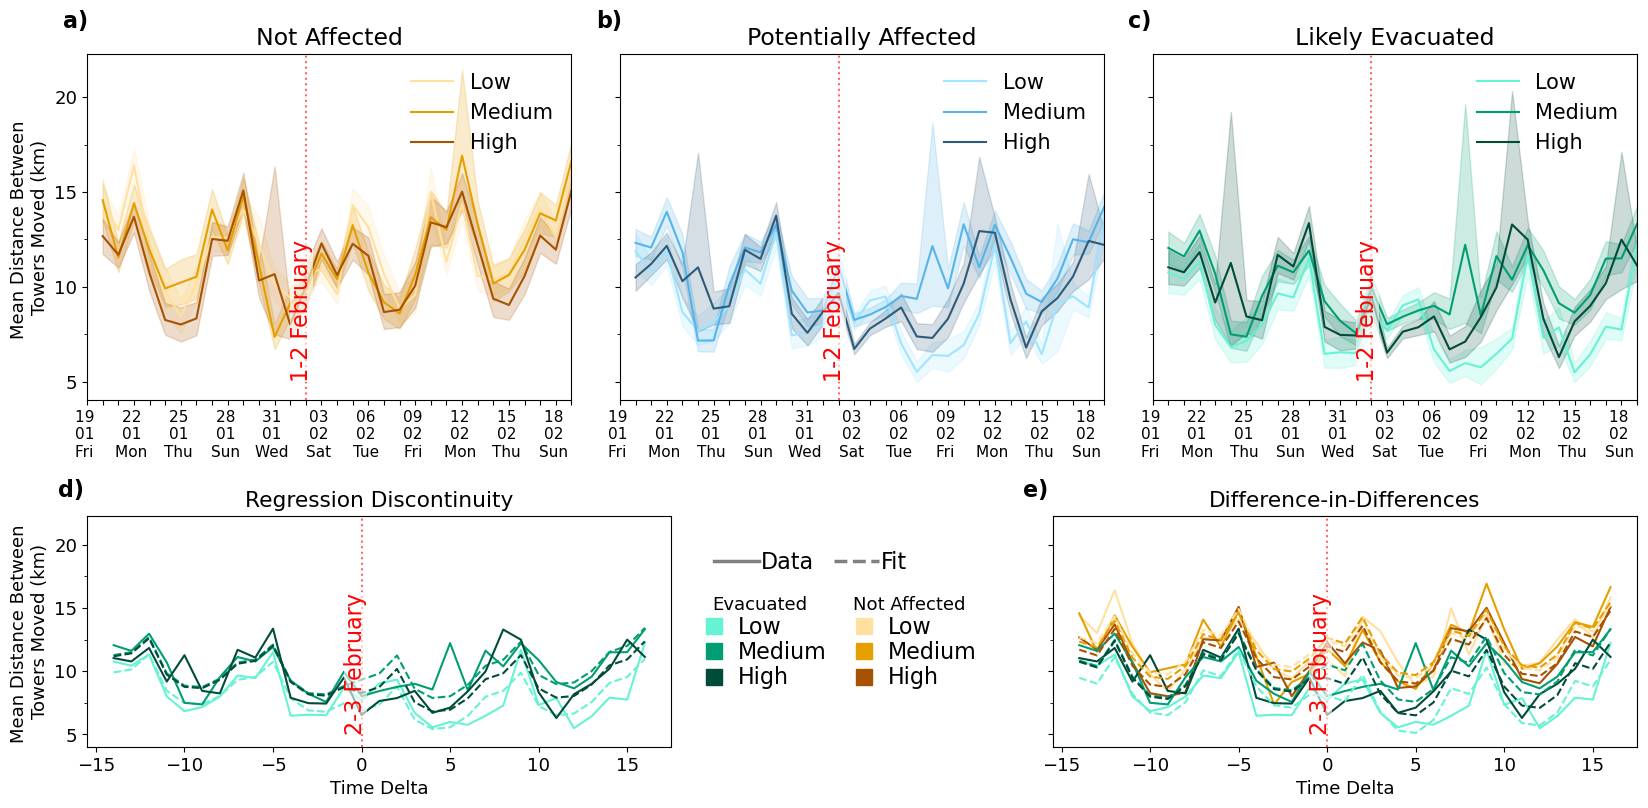

In [11]:
######## Figure 5 ########

fig, axs = plt.subplot_mosaic([
    ['a', 'b', 'c',],
    ['d', 'ee', 'e']], 
    #layout="constrained"
    figsize =(20, 9), height_ratios=[1.5,1],width_ratios=[1,1,1],
                             sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0.4})

for e in ['ee']: fig.delaxes(axs[e])

b = axs['d'].get_position()
# b.x0 = b.x0 + 0.15
b.x1 = b.x1 + 0.05
axs['d'].set_position(b)

b = axs['e'].get_position()
b.x0 = b.x0 - 0.05
axs['e'].set_position(b)


# Creating the line plots on the first row

# Creating the line plot on ax1
sns.lineplot(data=homelocations_merged[(homelocations_merged['affected'] == 0)&(homelocations_merged['distance_km'] > 0)].dropna(subset=['home_bts_id','quantile_pop_bins_percent_bachelor_home']), 
             x='date', y='distance_km',
             errorbar='ci', n_boot=1000, seed=10, estimator='mean',
             hue='quantile_pop_bins_percent_bachelor_home', hue_order=['Low','Medium','High'], 
             ax=axs['a'], legend=True,
             palette=[lighter_orange,orange,darker_orange])
sns.lineplot(data=homelocations_merged[(homelocations_merged['affected'] == 1)&(homelocations_merged['distance_km'] > 0)].dropna(subset=['home_bts_id','quantile_pop_bins_percent_bachelor_home']), 
             x='date', y='distance_km',
             errorbar='ci', n_boot=1000, seed=10, estimator='mean',
             hue='quantile_pop_bins_percent_bachelor_home', hue_order=['Low','Medium','High'], 
             ax=axs['b'], legend=True,
             palette=[lighter_blue,blue,darker_blue])
sns.lineplot(data=homelocations_merged[(homelocations_merged['PHONE_ID'].isin(evacuated_people))&(homelocations_merged['distance_km'] > 0)].dropna(subset=['home_bts_id','quantile_pop_bins_percent_bachelor_home']), 
             x='date', y='distance_km',
             errorbar='ci', n_boot=1000, seed=10, estimator='mean',
             hue='quantile_pop_bins_percent_bachelor_home', hue_order=['Low','Medium','High'], 
             ax=axs['c'], legend=True,
             palette=[lighter_green,green,darker_green])

titles=['Not Affected', 'Potentially Affected', 'Likely Evacuated']

unique_dates = homelocations_merged.drop_duplicates(subset=['date'])['date'].unique()
xticklabels = [date.strftime('%d \n%m \n%a ') if i % 3 == 0 else '' for i, date in enumerate(unique_dates)]

for ax, title in zip([axs['a'], axs['b'], axs['c']], titles):
    # Adding labels and title
    ax.set_title(title, size=17)
    ax.set_xlabel('')
    ax.set_ylabel('Mean Distance Between \nTowers Moved (km)')

    ax.set_xlim([datetime.datetime(2024, 1, 19), datetime.datetime(2024, 2, 19)])
    
    # Set x-axis to display only the dates
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    ax.axvline(x=datetime.datetime(2024, 2, 2), color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
    ax.text( x=datetime.datetime(2024, 2, 1), y=5, s='1-2 February',
            fontsize=16, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)
  
    # Setting x-ticks and labels based on homelocations_warned dataframe
    ax.set_xticks(unique_dates)
    ax.set_xticklabels(xticklabels, fontsize=11)

for ax in [axs['b'], axs['c']]:
    ax.set_ylabel('')
    ax.tick_params(labelleft=False)

for ax in [axs['a'], axs['b'], axs['c']]:
    handles, labels = ax.get_legend_handles_labels()
    custom_labels = ['Low', 'Medium', 'High']
    ax.legend(handles, custom_labels, title='', fontsize=15, loc='upper right', frameon=False)


# Bottom left

# Creating the subplot for Regression Discontinuity
for ses, color in zip(['Low', 'Medium', 'High'], [lighter_green, green, darker_green]):
    subset_ = rdd_df_ses_mean[rdd_df_ses_mean['quantile_pop_bins_percent_bachelor_home']==ses]
    subset_.plot.line(ax=axs['d'], x="time_delta", y="distance_km", color=color, legend=False)
    subset_.plot(x="time_delta", y="predictions", ax=axs['d'], color=color, linestyle='--', legend=False)

axs['d'].axvline(0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['d'].text(x=-1, y=5, s='2-3 February',
        fontsize=16, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)

axs['d'].set_title("Regression Discontinuity")
axs['d'].set_ylabel('Mean Distance Between \nTowers Moved (km)')
axs['d'].set_xlabel('Time Delta')


# Bottom right 
# Creating the subplot for Difference-in-Differences
dd_df_ses_mean['combined_hue'] = dd_df_ses_mean['group'].astype(str) + '_' + dd_df_ses_mean['quantile_pop_bins_percent_bachelor_home'].astype(str)

# Plot original data
sns.lineplot(ax=axs['e'], x='time_delta', y='value', hue='combined_hue', data=dd_df_ses_mean, 
             palette=[lighter_orange,orange,darker_orange,lighter_green,green,darker_green], legend=False)

# Plot fitted predictions
sns.lineplot(ax=axs['e'], x='time_delta', y='predictions', hue='combined_hue', data=dd_df_ses_mean, 
             palette=[lighter_orange,orange,darker_orange,lighter_green,green,darker_green],  linestyle='--', legend=False)

axs['e'].axvline(0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['e'].text(x=-1, y=5, s='2-3 February',
        fontsize=16, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)


axs['e'].set_title("Difference-in-Differences")
axs['e'].set_ylabel('Mean Distance Between \nTowers Moved (km)')
axs['e'].set_xlabel('Time Delta')


c_evacuated   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  markersize=11, label=mod)) for c,mod in zip([lighter_green, green, darker_green],
                                                                                                                           ['Low','Medium','High'])]
c_notaffected =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  markersize=11, label=mod)) for c,mod in zip([lighter_orange, orange, darker_orange],
                                                                                                                           ['Low','Medium','High'])]

lines =[(Line2D([0],[0], marker='', color='grey', markerfacecolor='grey',ls=l,  lw=2.5, label=mod)) for l,mod in zip(['-', '--'],['Data','Fit'])]

fig.legend(handles=lines,bbox_to_anchor=(0.545  ,0.35), fontsize = 16, ncols= 2, frameon=False,columnspacing=0.9, handletextpad=0.1,labelspacing=0.15)
fig.legend(handles=c_evacuated,bbox_to_anchor=(0.505  ,0.3), fontsize = 16, title= 'Evacuated', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)
fig.legend(handles=c_notaffected,bbox_to_anchor=(0.58  ,0.3), fontsize = 16, title= 'Not Affected', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)

plots_l = ['a)', 'b)', 'c)', 'd)', 'e)']
for ia, ax in enumerate(fig.axes): 
    x,y = -0.05,1.06
    ax.text(x,y,  plots_l[ia],
        color = 'k',#'lightgreen',
        horizontalalignment='left',
        verticalalignment='bottom',
        weight = 'bold',
        transform=ax.transAxes,fontsize = 16)

plt.savefig('../visuals_created/km_moved_ses_mean.pdf', bbox_inches = 'tight')

##########################



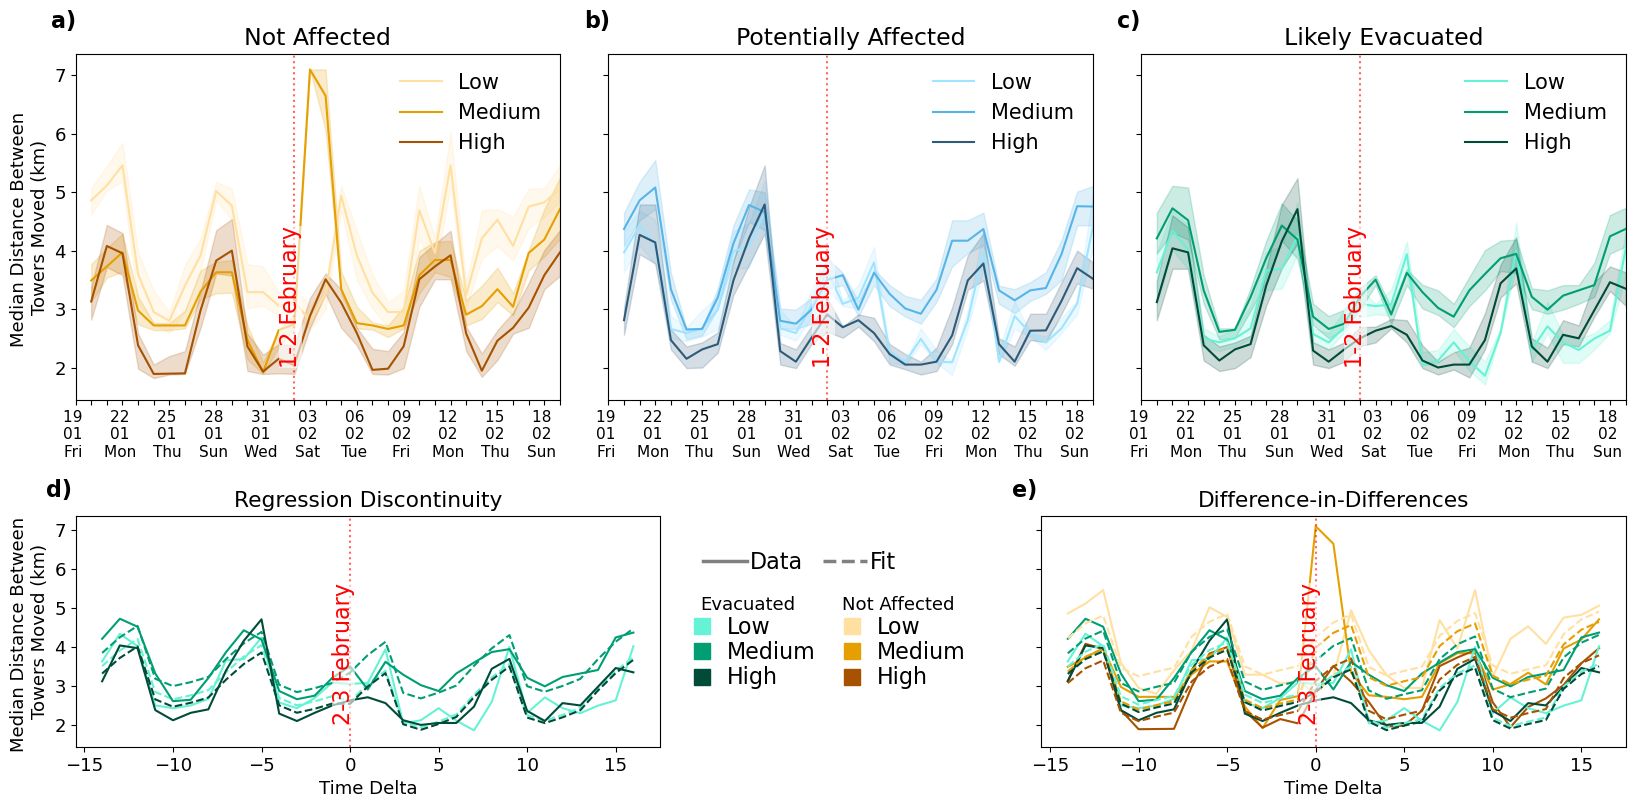

In [12]:
######## Figure 6 ########

fig, axs = plt.subplot_mosaic([
    ['a', 'b', 'c',],
    ['d', 'ee', 'e']], 
    #layout="constrained"
    figsize =(20, 9), height_ratios=[1.5,1],width_ratios=[1,1,1],
                             sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0.4})

for e in ['ee']: fig.delaxes(axs[e])

b = axs['d'].get_position()
# b.x0 = b.x0 + 0.15
b.x1 = b.x1 + 0.05
axs['d'].set_position(b)

b = axs['e'].get_position()
b.x0 = b.x0 - 0.05
axs['e'].set_position(b)


# Creating the line plots on the first row

# Creating the line plot on ax1
sns.lineplot(data=homelocations_merged[(homelocations_merged['affected'] == 0)&(homelocations_merged['distance_km'] > 0)].dropna(subset=['home_bts_id','quantile_pop_bins_percent_bachelor_home']), 
             x='date', y='distance_km',
             errorbar='ci', n_boot=1000, seed=10, estimator='median',
             hue='quantile_pop_bins_percent_bachelor_home', hue_order=['Low','Medium','High'], 
             ax=axs['a'], legend=True,
             palette=[lighter_orange,orange,darker_orange])
sns.lineplot(data=homelocations_merged[(homelocations_merged['affected'] == 1)&(homelocations_merged['distance_km'] > 0)].dropna(subset=['home_bts_id','quantile_pop_bins_percent_bachelor_home']), 
             x='date', y='distance_km',
             errorbar='ci', n_boot=1000, seed=10, estimator='median',
             hue='quantile_pop_bins_percent_bachelor_home', hue_order=['Low','Medium','High'], 
             ax=axs['b'], legend=True,
             palette=[lighter_blue,blue,darker_blue])
sns.lineplot(data=homelocations_merged[(homelocations_merged['PHONE_ID'].isin(evacuated_people))&(homelocations_merged['distance_km'] > 0)].dropna(subset=['home_bts_id','quantile_pop_bins_percent_bachelor_home']), 
             x='date', y='distance_km',
             errorbar='ci', n_boot=1000, seed=10, estimator='median',
             hue='quantile_pop_bins_percent_bachelor_home', hue_order=['Low','Medium','High'], 
             ax=axs['c'], legend=True,
             palette=[lighter_green,green,darker_green])

titles=['Not Affected', 'Potentially Affected', 'Likely Evacuated']

unique_dates = homelocations_merged.drop_duplicates(subset=['date'])['date'].unique()
xticklabels = [date.strftime('%d \n%m \n%a ') if i % 3 == 0 else '' for i, date in enumerate(unique_dates)]

for ax, title in zip([axs['a'], axs['b'], axs['c']], titles):
    # Adding labels and title
    ax.set_title(title, size=17)
    ax.set_xlabel('')
    ax.set_ylabel('Median Distance Between \nTowers Moved (km)')

    ax.set_xlim([datetime.datetime(2024, 1, 19), datetime.datetime(2024, 2, 19)])
    
    # Set x-axis to display only the dates
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    ax.axvline(x=datetime.datetime(2024, 2, 2), color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
    ax.text( x=datetime.datetime(2024, 2, 1), y=2, s='1-2 February',
            fontsize=16, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)
  
    # Setting x-ticks and labels based on homelocations_warned dataframe
    ax.set_xticks(unique_dates)
    ax.set_xticklabels(xticklabels, fontsize=11)

for ax in [axs['b'], axs['c']]:
    ax.set_ylabel('')
    ax.tick_params(labelleft=False)

for ax in [axs['a'], axs['b'], axs['c']]:
    handles, labels = ax.get_legend_handles_labels()
    custom_labels = ['Low', 'Medium', 'High']
    ax.legend(handles, custom_labels, title='', fontsize=15, loc='upper right', frameon=False)


# Bottom left

# Creating the subplot for Regression Discontinuity
for ses, color in zip(['Low', 'Medium', 'High'], [lighter_green, green, darker_green]):
    subset_ = rdd_df_ses_median[rdd_df_ses_median['quantile_pop_bins_percent_bachelor_home']==ses]
    subset_.plot.line(ax=axs['d'], x="time_delta", y="distance_km", color=color, legend=False)
    subset_.plot(x="time_delta", y="predictions", ax=axs['d'], color=color, linestyle='--', legend=False)

axs['d'].axvline(0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['d'].text(x=-1, y=2, s='2-3 February',
        fontsize=16, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)

axs['d'].set_title("Regression Discontinuity")
axs['d'].set_ylabel('Median Distance Between \nTowers Moved (km)')
axs['d'].set_xlabel('Time Delta')


# Bottom right 
# Creating the subplot for Difference-in-Differences
dd_df_ses_median['combined_hue'] = dd_df_ses_median['group'].astype(str) + '_' + dd_df_ses_median['quantile_pop_bins_percent_bachelor_home'].astype(str)

# Plot original data
sns.lineplot(ax=axs['e'], x='time_delta', y='value', hue='combined_hue', data=dd_df_ses_median, 
             palette=[lighter_orange,orange,darker_orange,lighter_green,green,darker_green], legend=False)

# Plot fitted predictions
sns.lineplot(ax=axs['e'], x='time_delta', y='predictions', hue='combined_hue', data=dd_df_ses_median, 
             palette=[lighter_orange,orange,darker_orange,lighter_green,green,darker_green],  linestyle='--', legend=False)

axs['e'].axvline(0, color='red', linestyle=':', lw =1.5, alpha = 0.6, zorder=100)
axs['e'].text(x=-1, y=2, s='2-3 February',
        fontsize=16, rotation='vertical', verticalalignment='bottom', color='red', bbox=dict(facecolor='w', edgecolor='none', pad=0.0, alpha=0.6), zorder=100)


axs['e'].set_title("Difference-in-Differences")
axs['e'].set_ylabel('Median Distance Between \nTowers Moved (km)')
axs['e'].set_xlabel('Time Delta')


c_evacuated   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  markersize=11, label=mod)) for c,mod in zip([lighter_green, green, darker_green],
                                                                                                                           ['Low','Medium','High'])]
c_notaffected =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  markersize=11, label=mod)) for c,mod in zip([lighter_orange, orange, darker_orange],
                                                                                                                           ['Low','Medium','High'])]

lines =[(Line2D([0],[0], marker='', color='grey', markerfacecolor='grey',ls=l,  lw=2.5, label=mod)) for l,mod in zip(['-', '--'],['Data','Fit'])]

fig.legend(handles=lines,bbox_to_anchor=(0.545  ,0.35), fontsize = 16, ncols= 2, frameon=False,columnspacing=0.9, handletextpad=0.1,labelspacing=0.15)
fig.legend(handles=c_evacuated,bbox_to_anchor=(0.505  ,0.3), fontsize = 16, title= 'Evacuated', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)
fig.legend(handles=c_notaffected,bbox_to_anchor=(0.58  ,0.3), fontsize = 16, title= 'Not Affected', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)

plots_l = ['a)', 'b)', 'c)', 'd)', 'e)']
for ia, ax in enumerate(fig.axes): 
    x,y = -0.05,1.06
    ax.text(x,y,  plots_l[ia],
        color = 'k',#'lightgreen',
        horizontalalignment='left',
        verticalalignment='bottom',
        weight = 'bold',
        transform=ax.transAxes,fontsize = 16)

plt.savefig('../visuals_created/km_moved_ses_median.pdf', bbox_inches = 'tight')